# Online Learning Experiments - Group Project

This notebook contains all experiments for the Online Learning project, organized in a modular and scalable way.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Experiment Configuration Framework](#framework)
3. [Task 1.1: UCB1 Simple Pricing](#task1_1)
4. [Task 1.2: Constrained UCB Pricing](#task1_2)
5. [Task 2.1: Combinatorial UCB Multi-Product](#task2_1)
6. [Task 3.1: Primal-Dual Non-Stationary](#task3_1)
7. [Task 4.1: Multi-Product Primal-Dual](#task4_1)
8. [Task 5.1: Sliding Window Non-Stationarity](#task5_1)

## Setup and Imports

In [ ]:
%load_ext autoreload
%autoreload 2

print("Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

from environments import *
from agents import *
from data_generators import *
from utils import *
from runner import *
from plotter import *
from scipy.stats import beta,truncnorm

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completed successfully!")


Setup completed successfully!


## <a id="task1_1"></a>Task 1.1: UCB1 Simple Pricing

Implementation of UCB1 for the pricing problem with uniform valuations.

In [ ]:
class Task1_1_Runner(StandardExperimentRunner):
    """UCB1 Simple Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = PricingEnvironment(
            self.prices, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env

    def create_agent(self):
        self.agent = UCB1(len(self.prices), self.config.horizon)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        if self.distribution == Distribution.UNIFORM:
            self.probabilities = 1 - self.prices

        elif self.distribution == Distribution.BETA:
            self.probabilities = 1 - beta.cdf(self.prices, 0.5, 2)

        elif self.distribution == Distribution.NORMAL:
            # Stessi parametri dell'ambiente: mu=0.5, sigma=0.15, troncata su [0,1]
            mu, sigma = 0.5, 0.15
            a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
            dist = truncnorm(a, b, loc=mu, scale=sigma)
            self.probabilities = 1.0 - dist.cdf(self.prices)

        else:
            raise ValueError(f"Distribution {self.distribution} not supported")
        print(f"Sell Probabilities: {self.probabilities}")
        self.expected_revenues = self.prices * self.probabilities
        print(f"Expected Revenues: {self.expected_revenues}")
        self.best_idx = np.argmax(self.expected_revenues)
        print(f"Best price index: {self.best_idx}, Expected revenue: {self.expected_revenues[self.best_idx]}")
        self.clairvoyant_reward_per_round = self.expected_revenues[self.best_idx]
        return self.clairvoyant_reward_per_round
    def extract_metrics(self, result) -> tuple[float, float]:
        # L'ambiente di Task 1.1 restituisce solo il ricavo come float
        reward = float(result) if not isinstance(result, tuple) else float(result[0])
        units = 1.0 if reward > 0.0 else 0.0
        return reward, units



price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 1.1 - UCB1 Simple Pricing",
    horizon=20_000,
    n_trials=3,
    seed=18,
    prices=price_grid,
    distribution=[Distribution.UNIFORM, Distribution.BETA, Distribution.NORMAL],
)

print("Task 1.1 - UCB1 Simple Pricing")
print(f"Prices: {price_grid}")

# Esegui gli esperimenti
multi_runner = MultiDistributionRunner(Task1_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=False)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task1_2"></a>Task 1.2: Constrained UCB Pricing

Implementation of Constrained UCB for pricing with budget constraints.


In [ ]:
class Task1_2_Runner(StandardExperimentRunner):
    """Constrained UCB Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.distribution = config.distribution
        self.adaptive_rho = config.adaptive_rho

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = BudgetedPricingEnvironment(
            self.prices, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env

    def create_agent(self):
        self.agent = UCBBudget(
            len(self.prices), self.config.budget, self.config.horizon, alpha=2, adaptive_rho=self.adaptive_rho)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        if self.distribution == Distribution.UNIFORM:
            self.sell_probabilities = np.maximum(0, 1 - self.prices)
            print(f"Sell Probabilities Uniform : {self.sell_probabilities}")
            print(f"Expected Revenues Uniform : {self.prices * self.sell_probabilities}")

        elif self.distribution == Distribution.BETA:
            # Coerente con l’ambiente BudgetedPricingEnvironment (beta(2,5))
            self.sell_probabilities = 1 - beta.cdf(self.prices, 2, 5)
            print(f"Sell Probabilities Beta : {self.sell_probabilities}")
            print(f"Expected Revenues Beta : {self.prices * self.sell_probabilities}")

        elif self.distribution == Distribution.NORMAL:
            # Coerente con l’ambiente: N(0.5, 0.15^2) troncata/clip su [0,1]
            mu, sigma = 0.5, 0.15
            a, b = (0.0 - mu) / sigma, (1.0 - mu) / sigma
            dist = truncnorm(a, b, loc=mu, scale=sigma)
            self.sell_probabilities = 1.0 - dist.cdf(self.prices)
            print(f"Sell Probabilities Normal : {self.sell_probabilities}")
            print(f"Expected Revenues Normal : {self.prices * self.sell_probabilities}")

        else:
            raise ValueError(f"Distribution {self.distribution} not supported")

        self.expected_reward = self.prices * self.sell_probabilities
        self.exp_util, self.gamma, self.exp_cost = compute_clairvoyant_single_product(
            self.prices, self.sell_probabilities, self.config.budget, self.config.horizon
        )
        return self.exp_util

    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result[0]), float(result[1])


price_grid = np.concatenate([np.linspace(0.1, 1.0, 10), [1.1]])
config = ExperimentConfig(
    task_name="Task 1.2 - Constrained UCB Pricing",
    horizon=20_000,
    n_trials=3,
    seed=18,
    budget=12_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM,Distribution.NORMAL],
    adaptive_rho=False
)

print("Task 1.2 - Constrained UCB Pricing")
print(
    f"Prices: {len(price_grid)} prices from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

multi_runner = MultiDistributionRunner(Task1_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

##NOTE: Se vuoi evitare quel comportamento della normale e confrontare solo fino a quando l’agente può agire:
# In run_single_trial->: 
# if action is None:
#     if not flag:
#         print(f"Trial {trial+1}: Agent stopped at round {t}.", end=" ")
#         flag = True
#     # registra lo stato corrente e termina il trial
#     regrets.append(cum_regret)
#     units_sold.append(int(cum_units))
#     break

## <a id="task2_1"></a>Task 2.1: Combinatorial UCB Multi-Product

Implementation of Constrained Combinatorial UCB for multi-product pricing with shared budget.


Task 2.1 - Combinatorial UCB Multi-Product
Products: 3, Prices per product: 10
Budget: 15000, Horizon: 10000

=== Eseguendo esperimento con distribuzione Beta ===
Running Task 2.1 - Combinatorial UCB Multi-Product (Beta)
Horizon: 10000, Trials: 1
Trial 1/1... Expected cost: 1.5000
Optimal expected revenue per round: 0.4731
Optimal distribution (simplex): [0.         0.         0.17164006 0.82835994 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
f_true: [array([9.90769788e-02, 1.74032075e-01, 1.75260356e-01, 1.11702795e-01,
       4.48913574e-02, 1.05057249e-02, 1.16596413e-03, 3.68397517e-05,
       6.15637350e-08, 0.00000000e+00, 0.00000000e+00]), array([9.90769788e-02, 1.74032075e-01, 1.75260356e-01, 1.11702795e-01,
       4.48913574e-02, 1.05057249e

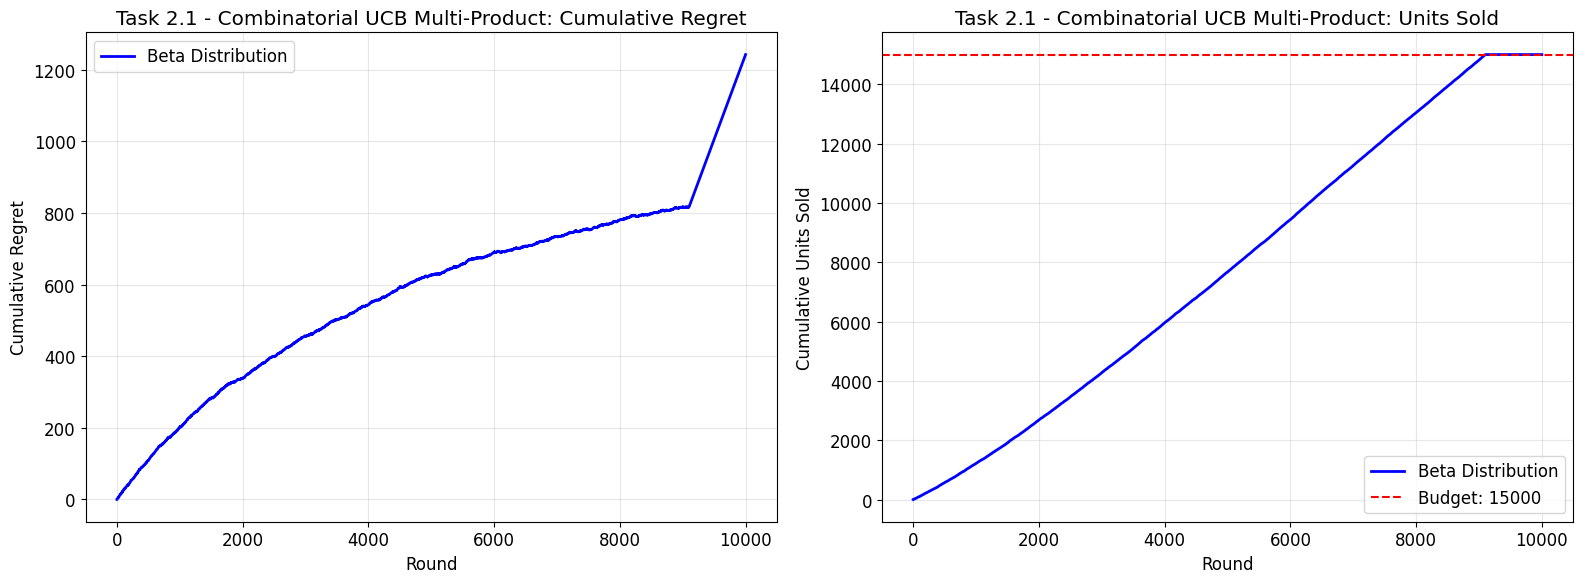


=== ANALISI DETTAGLIATA ===

--- Distribuzione Beta ---

RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product (Beta)
Execution time: 28.37 seconds
Completed rounds: 10000
Average regret per round: 0.124213
Average final reward: 3489.20 ± 0.00
Efficiency vs clairvoyant: 73.7%
Average units sold: 15001.00/15000 (100.0%)
Empirical average rewards: [[0.0993 0.1751 0.1765 0.1073 0.0543 0.0059 0.0024 0.     0.     0.
  0.    ]
 [0.0993 0.1735 0.1768 0.1046 0.0521 0.0194 0.0024 0.     0.     0.
  0.    ]
 [0.0989 0.1715 0.1735 0.1126 0.0422 0.002  0.0023 0.     0.     0.
  0.    ]]

=== CONFRONTO FINALE ===
Beta: Final Average Regret = 1242.1253, Final Average Reward = 3489.2000


In [10]:
class Task2_1_Runner(StandardExperimentRunner):
    """Combinatorial UCB Multi-Product experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.distribution = config.distribution
        self.price_grid = [np.concatenate([config.prices, [1.001]]) for _ in range(self.n_products)]
        self.adaptive_rho = config.adaptive_rho
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = MultiProductPricingEnvironment(self.price_grid, self.config.horizon, rng=rng, distribution=self.distribution)
        return self.env
        
    def create_agent(self):
        self.agent = ConstrainedCombinatorialUCBAgent(self.price_grid, self.config.budget, self.config.horizon, alpha=2, adaptive_rho=self.adaptive_rho)
        return self.agent
        
    def compute_clairvoyant_reward(self) -> float:
        if self.distribution == Distribution.UNIFORM:
            f_true = [prices * np.maximum(0, (1 - prices)) for prices in self.price_grid]
            c_true = [np.maximum(0, 1 - prices) for prices in self.price_grid]
        elif self.distribution == Distribution.BETA:
            f_true = [prices * (1 - beta.cdf(prices, 5, 10)) for prices in self.price_grid]
            c_true = [1 - beta.cdf(prices, 5, 10) for prices in self.price_grid]
        else:
            raise ValueError(f"Distribution {self.distribution} not supported")

        self.clair_reward, self.simplex = solve_clairvoyant_lp(self.price_grid, self.config.budget, self.config.horizon, f_true, c_true)

        print(f"f_true: {f_true}, c_true: {c_true}")

        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))

n_products = 3
price_grid = np.linspace(0.1, 1.0, 10)

config = ExperimentConfig(
    task_name="Task 2.1 - Combinatorial UCB Multi-Product",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=15_000,
    prices=price_grid,
    n_products=n_products,
    distribution=[Distribution.BETA  ],  #Distribution.UNIFORM
    adaptive_rho=False
)

print("Task 2.1 - Combinatorial UCB Multi-Product")
print(f"Products: {n_products}, Prices per product: {len(price_grid)}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

multi_runner = MultiDistributionRunner(Task2_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task3_1"></a>Task 3.1: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


In [ ]:
class Task3_1_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.05 #extra parameter for non-stationarity
        self.freq = 50
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq,num_regimes=int(config.horizon / 4), distribution=self.distribution, rng=rng
        )
        return self.env

    def create_agent(self):
        eta = 1 / np.sqrt(self.config.horizon)
        
        self.agent = FFPrimalDualPricingAgent(
            self.prices, self.config.horizon, self.config.budget, eta=eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        sell_probabilities = self.env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )

        return exp_util

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.1 - Primal-Dual Non-Stationary Pricing",
    horizon=20_000,
    n_trials=1,
    seed=17,
    budget=6_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM_SINUSOIDAL, Distribution.PIECEWISE_BETA]
)

print("Task 3.1 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(price_grid)} from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")

multi_runner = MultiDistributionRunner(Task3_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 3.1 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_hedge_probabilities(
        result.final_agents[0], title=f"Task 3.1 - Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## <a id="task3_2"></a>Task 3.2: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


In [ ]:
class Task3_2_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.05
        self.freq = 50
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq,
            num_regimes= int(self.config.horizon / 4), rng=rng, distribution=self.distribution
        )
        return self.env

    def create_agent(self):
        self.agent = BanditFeedbackPrimalDual(
            self.prices, self.config.horizon, self.config.budget)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        sell_probabilities = self.env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )
        return exp_util

price_grid = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.2 - Primal-Dual Non-Stationary Pricing",
    horizon=100_000,
    n_trials=1,
    seed=17,
    budget=30_000,
    prices=price_grid,
    distribution=[Distribution.BETA, Distribution.UNIFORM_SINUSOIDAL, Distribution.PIECEWISE_BETA]
)

print("Task 3.2 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(price_grid)} from {price_grid[0]:.3f} to {price_grid[-2]:.3f}")

multi_runner = MultiDistributionRunner(Task3_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 3.2 - Lambda (λ) Over Time - {name}")
    
    if hasattr(result.final_agents[0], 'hedge_weight_history'):
        StandardPlotter.plot_hedge_probabilities(
            result.final_agents[0], title=f"Task 3.2 - Hedge Probabilities Over Time - {name}")
    else:
        print(f"Hedge probabilities non disponibili per {name} (Bandit Feedback)")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 4.1: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.


In [ ]:
class Task4_1_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.distribution = config.distribution
        
        self.phi = 0.0
        self.mu0, self.A, self.f = 0.5, 0.1, 100
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': self.config.horizon // 4
        }
        self.env = MultiProductBudgetedPricingEnvironment(self.config.horizon, self.n_products, valuation_params, distribution=self.distribution, rng=rng)
        return self.env

    def create_agent(self) -> MultiProductFFPrimalDualPricingAgent:
        eta = 1 / np.sqrt(self.config.horizon)
        self.agent = MultiProductFFPrimalDualPricingAgent(self.price_grid, self.config.horizon, self.config.budget, self.n_products, eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        exp_util, gamma, exp_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget)
        return exp_util

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.1 - Multi-Product Primal-Dual",
    horizon=10_000,
    n_trials=1,
    seed=42,
    budget=8_000,
    prices=prices,
    n_products=4,
    distribution=[Distribution.SIMPLE_TV, Distribution.PIECEWISE_TV]
)

print("Task 4.1 - Multi-Product Primal-Dual")
print(f"Products: 4, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print("Correlation parameters: μ₀=0.5, ρ₀=0.6")

multi_runner = MultiDistributionRunner(Task4_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 4.1 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 4.1 - Multi-Product Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 4.2: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.

In [ ]:
class Task4_2_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.distribution = config.distribution

        self.phi = 0.0
        self.mu0, self.A, self.f = 0.5, 0.1, 100
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': self.config.horizon // 4
        }
        self.env = MultiProductBudgetedPricingEnvironment(
            self.config.horizon, self.n_products, valuation_params, distribution=self.distribution, rng=rng, price_grid=self.price_grid
        )
        return self.env

    def create_agent(self) -> MultiProductPDExp3PricingAgent:
        eta = 1 / np.sqrt(self.config.horizon)
        self.agent = MultiProductPDExp3PricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, self.n_products, eta)
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        exp_util, gamma, exp_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget)
        return exp_util

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.2 - Multi-Product Primal-Dual",
    horizon=10_000,
    n_trials=1,
    seed=42,
    budget=9_000,
    prices=prices,
    n_products=3,
    distribution=[Distribution.PIECEWISE_TV, Distribution.SIMPLE_TV]
)

print("Task 4.2 - Multi-Product Primal-Dual")
print(f"Products: {config.n_products}, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print("Correlation parameters: μ₀=0.5, ρ₀=0.6")

multi_runner = MultiDistributionRunner(Task4_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True, show_budget=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 4.2 - Lambda (λ) Over Time - {name}")
    
    if hasattr(result.final_agents[0], 'hedge_prob_history'):
        StandardPlotter.plot_multi_hedge_probabilities(
            result.final_agents[0], 
            title=f"Task 4.2 - Multi-Product Hedge Probabilities Over Time - {name}")
    else:
        print(f"Multi-hedge probabilities non disponibili per {name} (EXP3.P Bandit Feedback)")

multi_runner.print_analysis()

multi_runner.plot_arm_distributions()

## Task 5.1: Sliding Window per Non-Stazionarietà

Implementazione di Constrained Combinatorial UCB con Sliding Window per adattamento locale a cambiamenti.


In [ ]:
class Task5_1_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = np.sqrt(self.config.horizon)
        self.window_size = int(
            (config.horizon * np.log(config.horizon)) ** (2/3))
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, rng=rng, 
            distribution=self.distribution, n_products=self.N_products, 
            num_windows=self.num_windows
        )
        return self.env

    def create_agent(self):
        self.agent = SlidingWindowConstrainedCombinatorialUCBAgent(
            self.price_grid, self.config.budget, self.config.horizon,
            window_size=self.window_size
        )
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        full_prices = self.price_grid[0]
        self.clairvoyant_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, full_prices, self.config.budget
        )
        return self.clairvoyant_reward

    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs, _ = result
        return float(np.sum(rewards)), float(np.sum(costs))

    def run_single_trial(self, trial: int) -> Tuple[List[float], List[int], float, Any]:
        """Run a single trial and return regrets, units sold, final reward, and final agent"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)

        self.env = self.create_environment(trial_seed)
        self.agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0.0

        clairvoyant_reward = self.compute_clairvoyant_reward()

        for t in range(self.config.horizon):
            action = self.agent.pull_arm()

            if action is None:
                print(f"Trial {trial+1}: Agent stopped at round {t}.", end=" ")
                break

            rewards, costs, _ = self.env.round(action)

            self.agent.update(rewards, costs)

            reward, cost = float(np.sum(rewards)), float(np.sum(costs))

            cum_reward += reward
            cum_units += cost

            instant_regret = clairvoyant_reward - reward
            cum_regret += instant_regret

            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        return regrets, units_sold, cum_reward, self.agent


base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.1 - Smooth Multi-Product Pricing",
    horizon=30_000,
    n_trials=1,
    seed=18,
    budget=40_000,
    prices=base_prices,
    n_products=3,
    n_windows=4,
    distribution=[Distribution.SMOOTH]
)

print("Task 5.1 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_1_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

multi_runner.print_analysis()

# 5.2 Comparison with Primal Dual Hedge

In [ ]:
class Task5_2_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = config.n_windows
        self.distribution = config.distribution
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, n_products=self.N_products, num_windows=self.num_windows, rng=rng, distribution=self.distribution
        )
        return self.env
        
    def create_agent(self):
        self.agent = MultiProductFFPrimalDualPricingAgent(
            self.price_grid, self.config.horizon, self.config.budget, 
            n_products = self.N_products, eta = 1 / np.sqrt(self.config.horizon)
        )
        return self.agent
        
    def compute_clairvoyant_reward(self) -> float:
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, self.price_grid[0], self.config.budget
        )
        return self.clair_reward
        
    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent()
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0

        self.compute_clairvoyant_reward()

        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None or np.any([c is None for c in choice]):
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, val = env.round(choice)
            
            agent.update(val)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if regrets is not None and len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent


base_prices = np.linspace(0, 1, 15)
config = ExperimentConfig(
    task_name="Task 5.2 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=8_000,
    prices=base_prices,
    n_products=3,
    n_windows=4,
    distribution=[Distribution.SMOOTH]
)

print("Task 5.2 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_2_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 5.2 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 5.2 - Multi-Product Hedge Probabilities Over Time - {name}")

# 5.3 Comparison with Primal Dual ExP3.P

In [ ]:
class Task5_3_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""

    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.n_products)
        ]
        self.num_windows = config.n_windows
        self.window_size = int(
            (config.horizon * np.log(config.horizon)) ** (2/3))
        self.distribution = config.distribution

    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        self.env = SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, n_products=self.n_products, num_windows=self.num_windows, rng=rng, distribution=self.distribution
        )
        return self.env

    def create_agent(self):
        self.agent = MultiProductPDExp3PricingAgent(
            self.price_grid, self.config.horizon, self.config.budget,
            n_products=self.n_products
        )
        return self.agent

    def compute_clairvoyant_reward(self) -> float:
        full_prices = self.price_grid[0]
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.env.valuations, full_prices, self.config.budget
        )
        return self.clair_reward

    def extract_metrics(self, result) -> Tuple[float, float]:
        rewards, costs, _ = result
        return float(np.sum(rewards)), float(np.sum(costs))

    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.3 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)

        env = self.create_environment(trial_seed)
        agent = self.create_agent()

        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0

        print(f"Trial {trial+1}/{self.config.n_trials}...")
        self.compute_clairvoyant_reward()

        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break

            rewards, costs, val = env.round(choice)
            agent.update(val)

            reward, cost = float(np.sum(rewards)), float(np.sum(costs))
            cum_reward += reward

            # Compute instantaneous regret
            instant_regret = self.clair_reward - reward
            cum_regret += instant_regret
            cum_units += cost
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(
            f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(
                f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")

        return regrets, units_sold, cum_reward, agent


base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.3 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=5_000,
    prices=base_prices,
    n_products=3,
    n_windows=4,
    distribution=[Distribution.SMOOTH]
)

print("Task 5.3 - Smooth Multi-Product Pricing")
print(f"Products: {config.n_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

multi_runner = MultiDistributionRunner(Task5_3_Runner, config)
results = multi_runner.run_experiment()

multi_runner.plot_comparison(show_units=True)

print("\n=== PLOT SPECIFICI PER OGNI DISTRIBUZIONE ===")
for name, result in results.items():
    print(f"\nPlot per distribuzione {name}:")
    
    StandardPlotter.plot_lambda(
        result.final_agents[0], title=f"Task 5.3 - Lambda (λ) Over Time - {name}")
    
    StandardPlotter.plot_multi_hedge_probabilities(
        result.final_agents[0], 
        title=f"Task 5.3 - Multi-Product Hedge Probabilities Over Time - {name}")

multi_runner.print_analysis()